## 1. Import Libraries

In [2]:
#!git clone https://github.com/tayfunai/CNN-BASED-CLASSIFICATION-MODELS.git

In [3]:
import os
import time
import random

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


In [4]:
"""In order force cuDNN to onyl use deterministic
algorithms which might be useful to produce
reproducible results we need following code"""

if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True

## 2. Model settings

In [5]:
# Setting a random seed
def set_all_seeds(seed):
  os.environ["PL_GLOBAL_SEED"] = str(seed)
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

In [6]:
# Setting cuDNN and PyTorch algorithmic behavior to deterministic
def set_deterministic():
  if torch.cuda_is_available():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
  torch.set_deterministic(True)

In [7]:
#### SETTINGS ####

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
BATCH_SIZE = 256
NUM_EPOCHS = 40

# Architecture
NUM_CLASSES=10

#Other
DEVICE = "cuda" if torch.cuda.is_available else "cpu"

set_all_seeds(RANDOM_SEED)

In [8]:
# Deterministic behavior not yet supported by AdaptiveAvgPool2d
#set_deterministic()


## 3. Import utility functions

In [9]:
import sys

# In order to import modules from a directory one level up.

sys.path.append('/content/CNN-BASED-CLASSIFICATION-MODELS/helper_functions')
sys.path.insert(0, "..")


In [10]:
from helper_evaluate import compute_accuracy, compute_epoch_loss

from helper_data import *

from helper_train import *



## 4. Dataset

In [11]:
!pip install tqdm

In [12]:
## Set random seed##
set_all_seeds(RANDOM_SEED)

### Dataset ###

train_transforms = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.RandomCrop((64, 64)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.CenterCrop((64, 64)),
    transforms.ToTensor()
])

train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    num_workers=2,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    validation_fraction=0.1
)

100%|██████████| 170M/170M [00:05<00:00, 28.6MB/s]


In [13]:
# Checking the dataset
print(f"Training set:\n")
for images, labels in train_loader:
  print(f"Image batch demensions: {images.size()}")
  print(f"Image label dimensions: {labels.size()}")
  print(labels[:10])
  break

# Checking the validation set
print(f"\nValidation set:")
for images, labels in valid_loader:
  print(f"Image batch demensions: {images.size()}")
  print(f"Image label dimensions: {labels.size()}")
  print(labels[:10])
  break

# Checking the testing set
print(f"\nTesting set:")
for images, labels in test_loader:
  print(f"Image batch demensions: {images.size()}")
  print(f"Image label dimensions: {labels.size()}")
  print(labels[:10])
  break

Training set:

Image batch demensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([0, 2, 3, 5, 4, 8, 9, 6, 9, 7])

Validation set:
Image batch demensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([6, 9, 3, 5, 7, 3, 4, 1, 8, 0])

Testing set:
Image batch demensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])


## 5. Model

In [14]:
### MODEL ###

class AlexNet(nn.Module):
  def __init__(self, num_classes):
    super(AlexNet, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),

      nn.Conv2d(64, 192, kernel_size=5, padding=2, groups=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),

      nn.Conv2d(192, 384, kernel_size=3, padding=1, groups=2),
      nn.ReLU(inplace=True),

      nn.Conv2d(384, 256, kernel_size=3, padding=1, groups=2),
      nn.ReLU(inplace=True),

      nn.Conv2d(256, 256, kernel_size=3, padding=1, groups=2),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(256*6*6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), 256*6*6)
    logits = self.classifier(x)
    probas = F.softmax(logits, dim=1)
    return logits

In [15]:
torch.manual_seed(RANDOM_SEED)
model = AlexNet(NUM_CLASSES)
model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

## 6. Model training

In [16]:
log_dict = train_classifier_simple_v1(num_epochs=NUM_EPOCHS,
                                      model=model,
                                      optimizer=optimizer,
                                      device=DEVICE,
                                      train_loader=train_loader,
                                      valid_loader=valid_loader,
                                      logging_interval=50)

Epoch: 001/040 | Batch 0000/0175 | Loss: 2.3021
Epoch: 001/040 | Batch 0050/0175 | Loss: 2.0464
Epoch: 001/040 | Batch 0100/0175 | Loss: 1.9008
Epoch: 001/040 | Batch 0150/0175 | Loss: 1.9014
***Epoch: 001/040 | Train. Acc.: 32.752% | Loss: 1.738
***Epoch: 001/040 | Valid. Acc.: 33.140% | Loss: 1.711
Time elapsed: 1.00 min
Epoch: 002/040 | Batch 0000/0175 | Loss: 1.7056
Epoch: 002/040 | Batch 0050/0175 | Loss: 1.6665
Epoch: 002/040 | Batch 0100/0175 | Loss: 1.6402
Epoch: 002/040 | Batch 0150/0175 | Loss: 1.5006
***Epoch: 002/040 | Train. Acc.: 40.605% | Loss: 1.577
***Epoch: 002/040 | Valid. Acc.: 41.380% | Loss: 1.558
Time elapsed: 1.89 min
Epoch: 003/040 | Batch 0000/0175 | Loss: 1.5153
Epoch: 003/040 | Batch 0050/0175 | Loss: 1.5639
Epoch: 003/040 | Batch 0100/0175 | Loss: 1.4702
Epoch: 003/040 | Batch 0150/0175 | Loss: 1.2859
***Epoch: 003/040 | Train. Acc.: 48.181% | Loss: 1.390
***Epoch: 003/040 | Valid. Acc.: 48.340% | Loss: 1.384
Time elapsed: 2.77 min
Epoch: 004/040 | Batch 00

## 7. Model Evaluation

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline


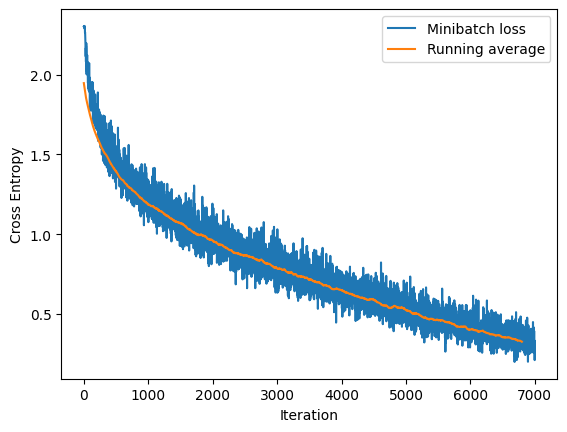

In [18]:
loss_list = log_dict['train_loss_per_batch']

plt.plot(loss_list, label='Minibatch loss')
plt.plot(np.convolve(loss_list,
                     np.ones(200,)/200, mode='valid'),
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

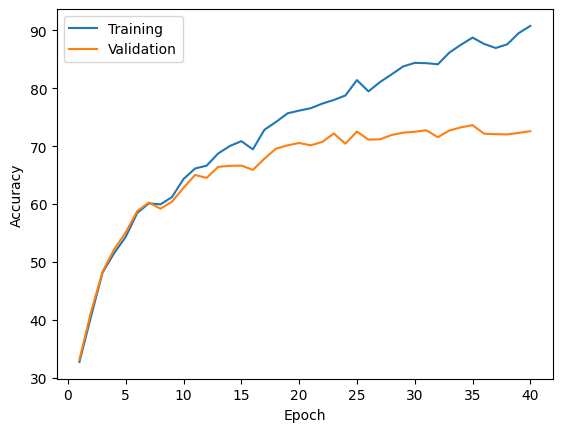

In [19]:
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['train_acc_per_epoch'], label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), log_dict['valid_acc_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
with torch.set_grad_enabled(False):

    train_acc = compute_accuracy(model=model,
                                 data_loader=test_loader,
                                 device=DEVICE)

    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)

    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)


print(f'Train ACC: {valid_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')


Train ACC: 72.58%
Validation ACC: 72.58%
Test ACC: 71.43%


## 8. Saving model

In [22]:
torch.save(model.state_dict(), "alexnet_weights.pth")


In [23]:
torch.save(model, "alexnet_model.pth")

In [28]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), groups=2)
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_featur

In [24]:
model.state_dict()

OrderedDict([('features.0.weight',
              tensor([[[[ 0.0219, -0.0230, -0.0083,  ...,  0.0053, -0.0101,  0.0099],
                        [-0.0050,  0.0166, -0.0218,  ...,  0.0144, -0.0228, -0.0358],
                        [-0.0160, -0.0263, -0.0205,  ...,  0.0146,  0.0490,  0.0332],
                        ...,
                        [-0.0048,  0.0318,  0.0163,  ...,  0.0143,  0.0109, -0.0158],
                        [-0.0148,  0.0495, -0.0100,  ..., -0.0020,  0.0356,  0.0152],
                        [ 0.0131,  0.0364,  0.0466,  ..., -0.0449, -0.0416, -0.0317]],
              
                       [[-0.0021,  0.0493, -0.0341,  ...,  0.0448, -0.0379,  0.0054],
                        [ 0.0339,  0.0288,  0.0284,  ..., -0.0277, -0.0108, -0.0373],
                        [ 0.0080,  0.0088, -0.0188,  ...,  0.0497, -0.0081, -0.0041],
                        ...,
                        [ 0.0267,  0.0096,  0.0148,  ..., -0.0426, -0.0191,  0.0517],
                        [-0.040